In [1]:
from cities.deployment.tracts_minneapolis.predict_new import TractsModelPredictor

from cities.utils.plot_ts import (plot_coefs, summarize_time_series,
                                  plot_model_summary, plot_selected_series)

from chirho.indexed.ops import IndexSet, gather, indices_of

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.interventional.handlers import do

from cities.utils.data_loader import db_connection
import time
import torch
import pyro


import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
start = time.time()
with db_connection() as conn:
    predictor = TractsModelPredictor(conn)

end = time.time()
print("Time elapsed:", end - start)

Time elapsed: 2.299088954925537


In [3]:
predictor.train_model(override=False, num_steps=4000)

[iteration 0001] loss: 287419.9688
[iteration 0050] loss: 28205.5801
[iteration 0100] loss: 15749.1182
[iteration 0150] loss: 13931.1807
[iteration 0200] loss: 11579.3223
[iteration 0250] loss: 10148.5410
[iteration 0300] loss: 10183.1660
[iteration 0350] loss: 9967.5654
[iteration 0400] loss: 9923.9033
[iteration 0450] loss: 10252.4141
[iteration 0500] loss: 9900.9297
[iteration 0550] loss: 9706.6621
[iteration 0600] loss: 9949.9902
[iteration 0650] loss: 9785.0693
[iteration 0700] loss: 9557.5381
[iteration 0750] loss: 9752.0107
[iteration 0800] loss: 9543.6426
[iteration 0850] loss: 9445.9756
[iteration 0900] loss: 9452.6455
[iteration 0950] loss: 9453.1426
[iteration 1000] loss: 9439.0752
[iteration 1050] loss: 9442.0000
[iteration 1100] loss: 9351.9736
[iteration 1150] loss: 9334.0537
[iteration 1200] loss: 9368.7549
[iteration 1250] loss: 9236.1416
[iteration 1300] loss: 9249.9844
[iteration 1350] loss: 9246.7432
[iteration 1400] loss: 9247.6865
[iteration 1450] loss: 9179.4092
[

/home/rafal/s78projects/cities/cities/utils/plot_ts.py:219: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


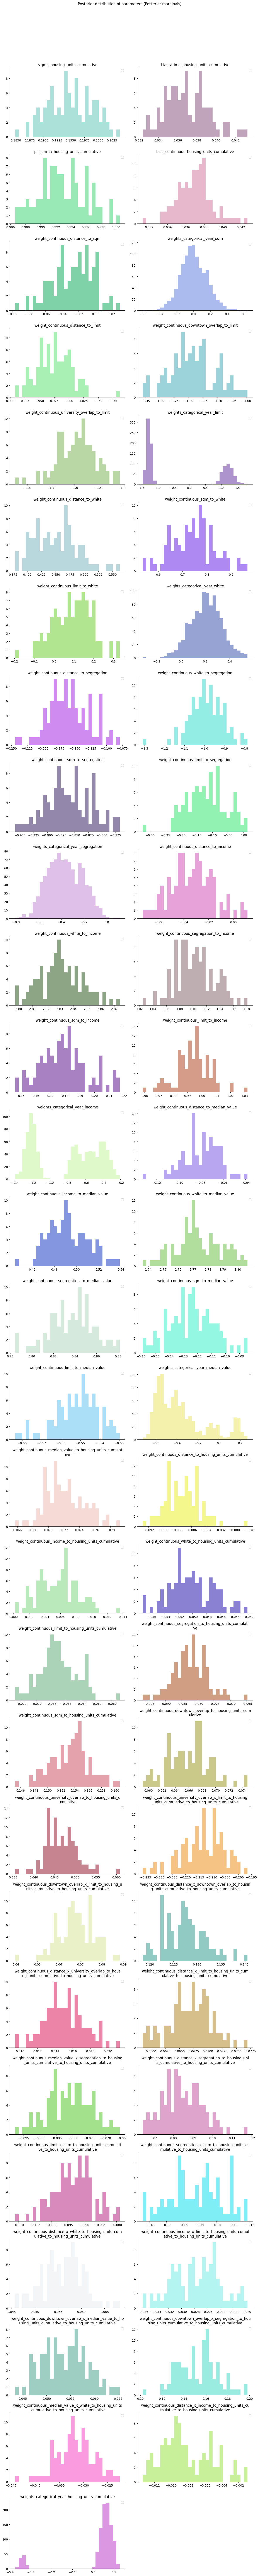

In [4]:
factual_samples = predictor.predictive(data = predictor.nonified_data) 

specific_names = ['sigma_housing_units_cumulative', 'bias_arima_housing_units_cumulative', 'phi_arima_housing_units_cumulative', 'bias_continuous_housing_units_cumulative']
weigth_names = [name for name in factual_samples.keys() if name.startswith("weight")]
param_sites = specific_names + weigth_names

assert all(name in factual_samples.keys() for name in param_sites)

plot_coefs(factual_samples, param_sites, true_params=None, title="Posterior marginals")

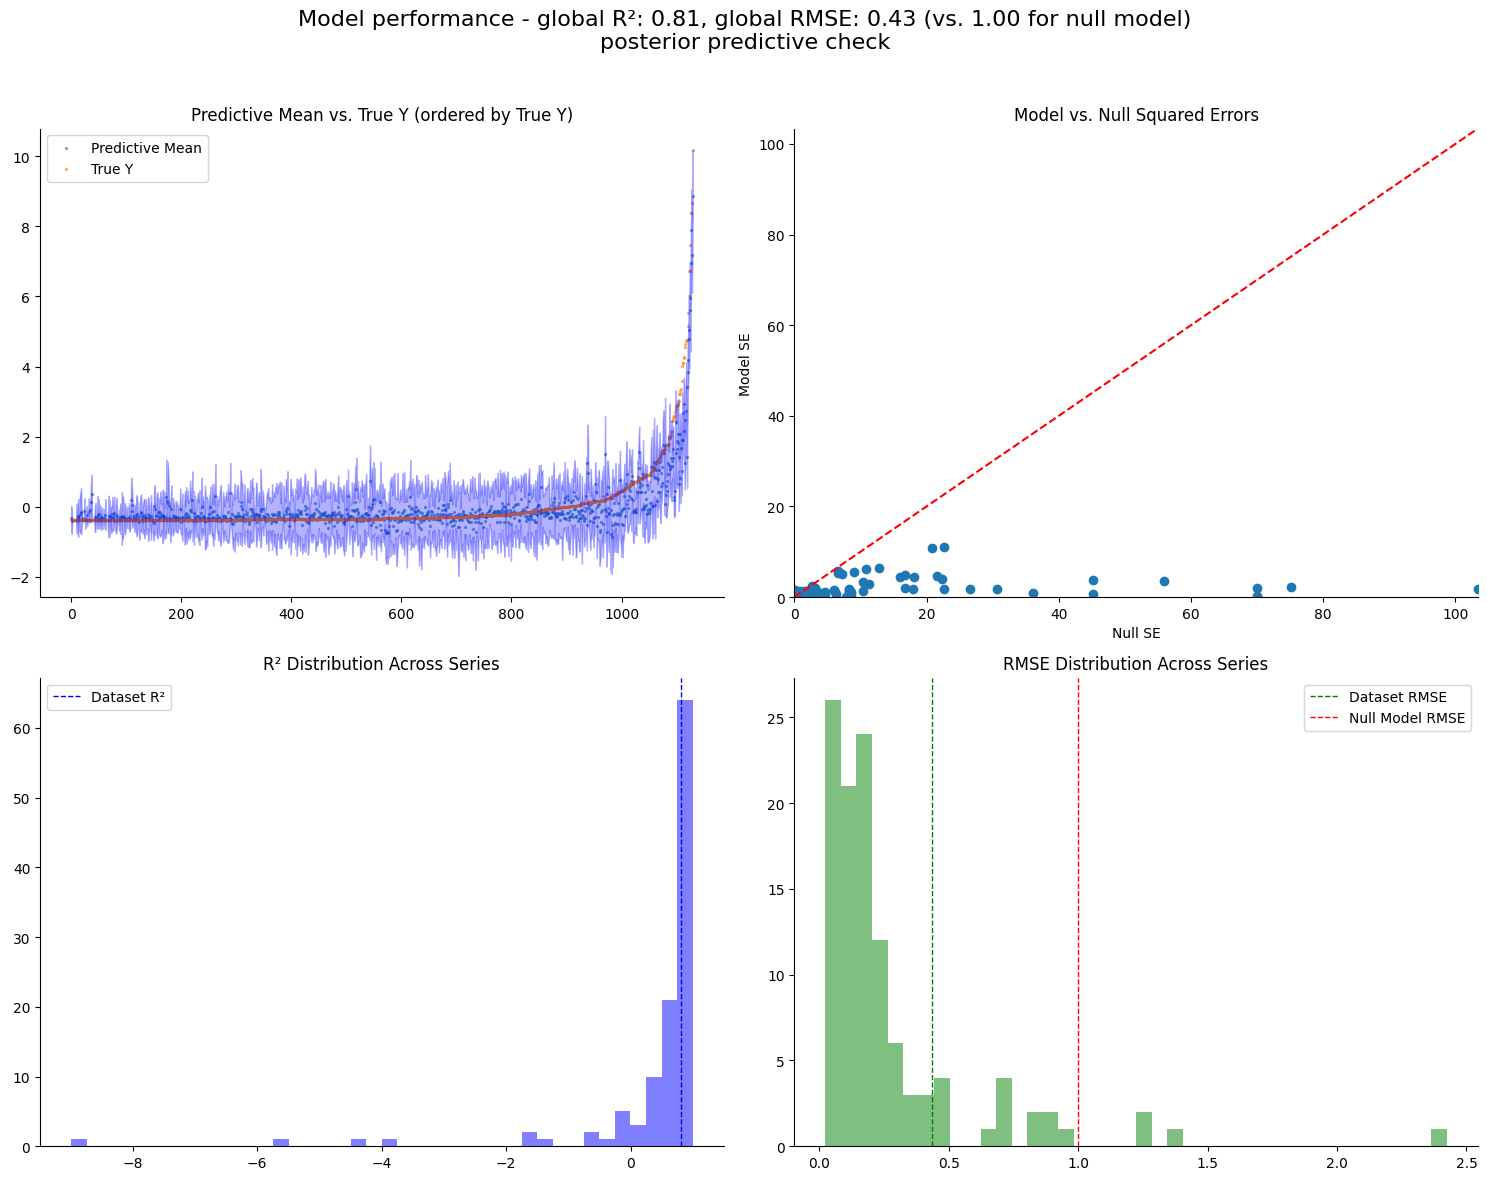

In [5]:
y_true = predictor.data['reshaped']['continuous']['housing_units_cumulative']
summary = summarize_time_series(factual_samples, y_true, y_site="predicted_housing_units_cumulative")
plot_model_summary(summary, y_true, title="posterior predictive check", 
                   path = "cumulative model evaluation.png")

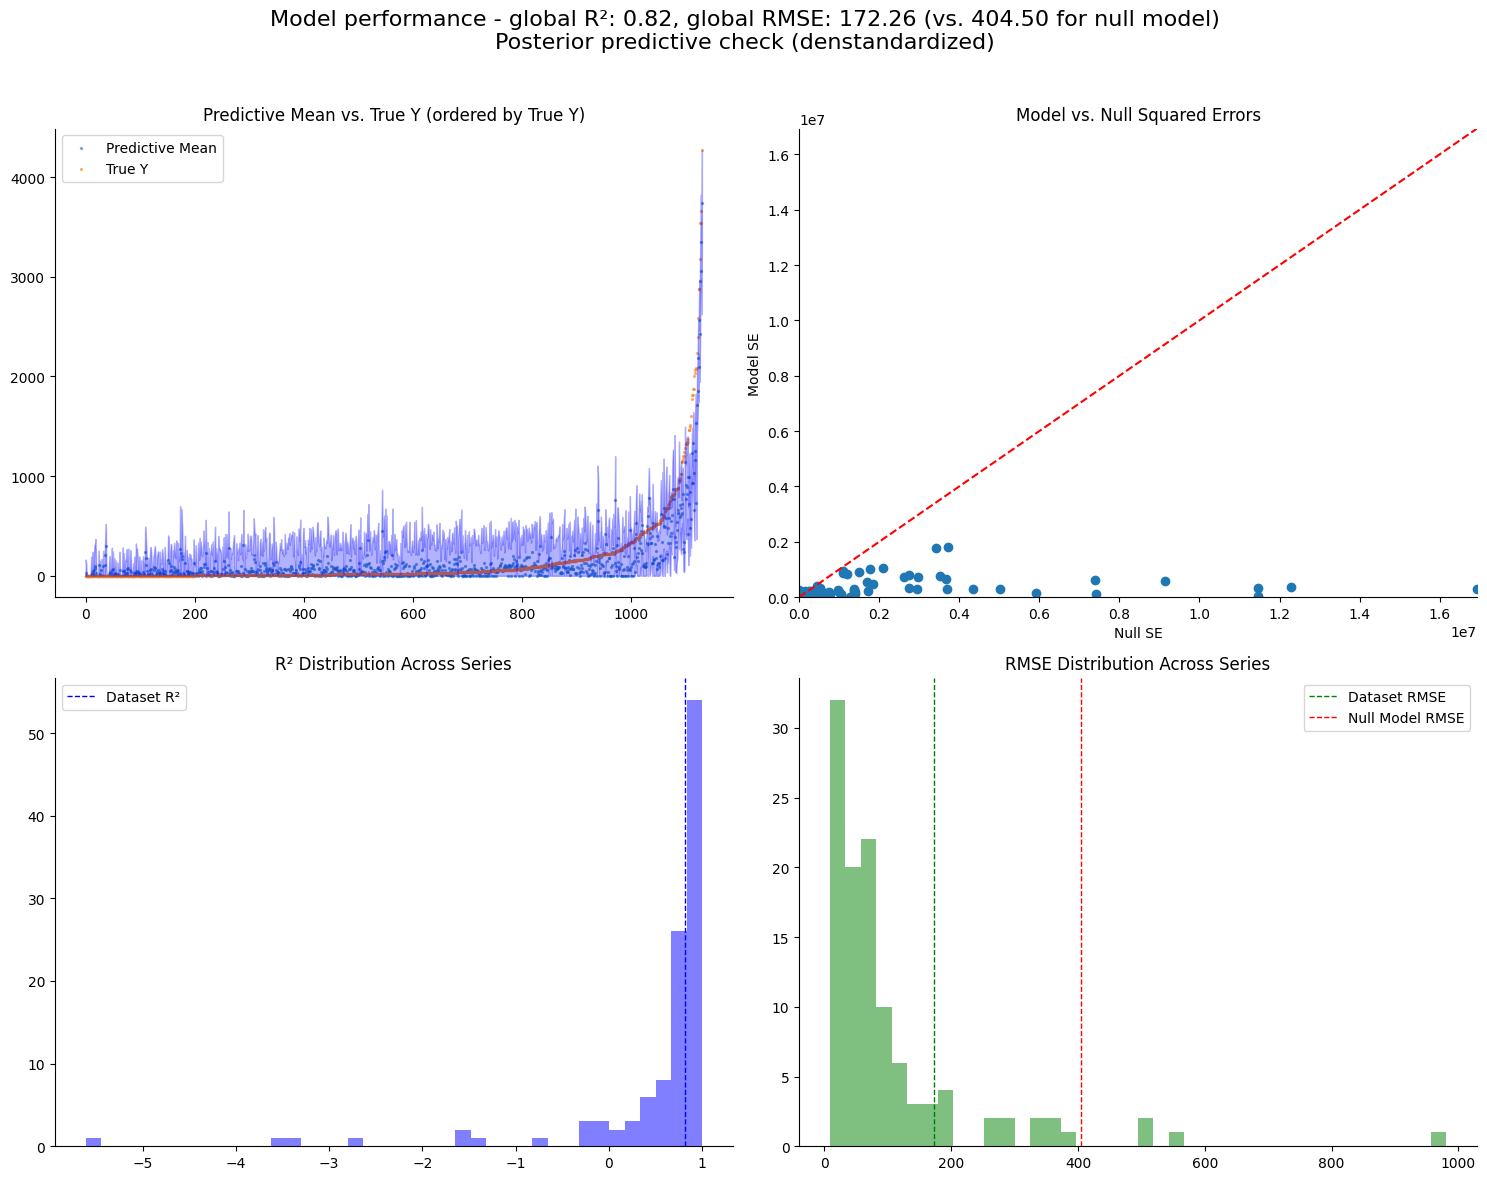

In [9]:
y_true_original = predictor.data['reshaped']['continuous']['housing_units_cumulative_original']

factual_samples['destandardized_housing_units_cumulative'] = (factual_samples['predicted_housing_units_cumulative'] *
                                                predictor.data['housing_units_cumulative_std'] +
                                                predictor.data['housing_units_cumulative_mean'])


summary_destandardized = summarize_time_series(factual_samples,
                                y_true_original, y_site="destandardized_housing_units_cumulative",
                                clamp_at_zero=True)

plot_model_summary(summary_destandardized, y_true_original, 
                   title="Posterior predictive check (denstandardized)",
                   path = "ts_model_summary_cumulative.png")


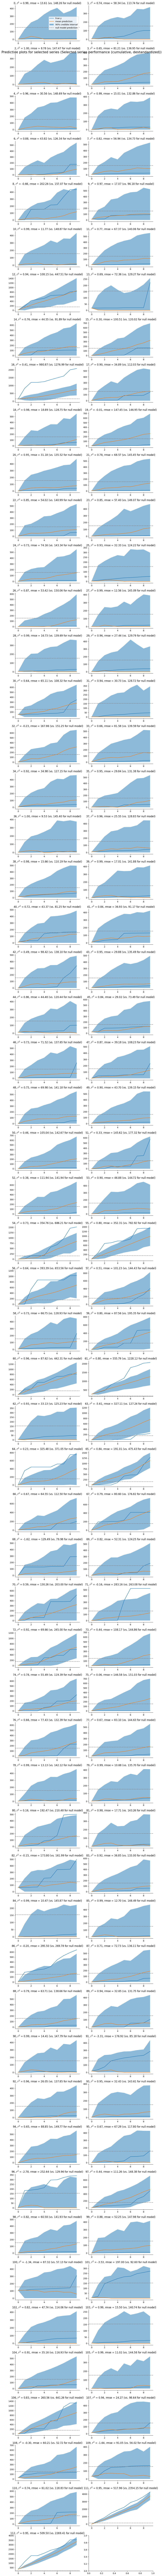

In [8]:
plot_selected_series = plot_selected_series

plot_selected_series(
    summary_destandardized,
    y_true_original,
    selected_series=range(113),
    title="Selected series performance (cumulative, destandardized)",
    plot_null=True,
    path = "ts_selected_series_destandardized_cumulative.png"
)

[]

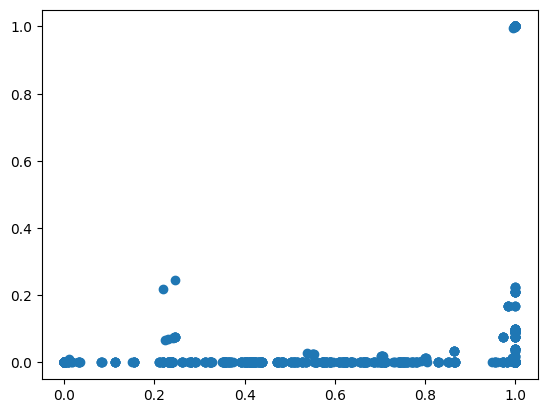

In [11]:
factual_intervention = {"radius_blue": 106.7, "limit_blue": 0, "radius_yellow_line": 402.3, "radius_yellow_stop": 804.7, "limit_yellow": 0.5, "reform_year": 2015}
extreme_intervention = {"radius_blue": 1400, "limit_blue": 0, "radius_yellow_line": 2640, "radius_yellow_stop": 4000, "limit_yellow": 0.3, "reform_year": 2012}


with db_connection() as conn:
    predictor = TractsModelPredictor(conn)
    factual_intervention = predictor._tracts_intervention(conn, **factual_intervention)
    extreme_intervention = predictor._tracts_intervention(conn, **extreme_intervention)


plt.scatter(factual_intervention, extreme_intervention)
plt.plot()

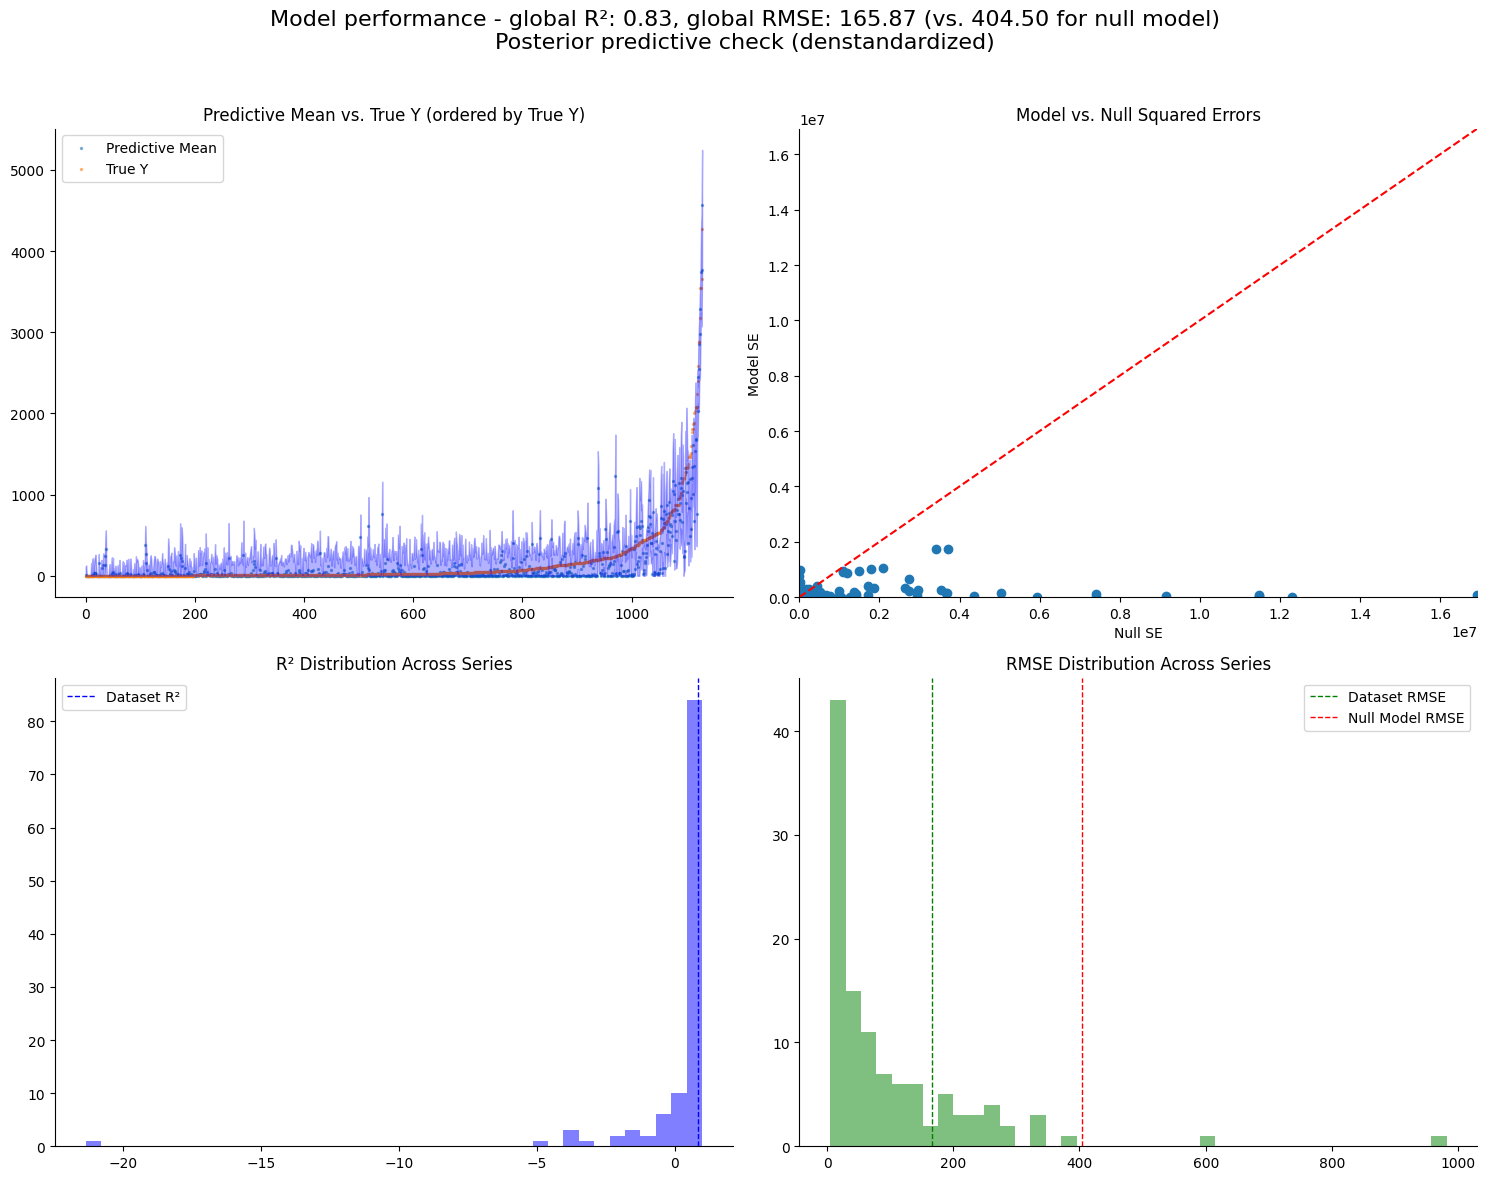

dict_keys(['mean_pred', 'mean_low', 'mean_high', 'total_null_se', 'total_model_se', 'series_mean_pred', 'series_low_pred', 'series_high_pred', 'total_r2', 'total_rmse', 'total_null_rmse', 'series_omean_pred', 'series_null_squared_errors', 'series_model_squared_errors', 'series_null_rmse', 'series_rmse', 'series_r2'])


[]

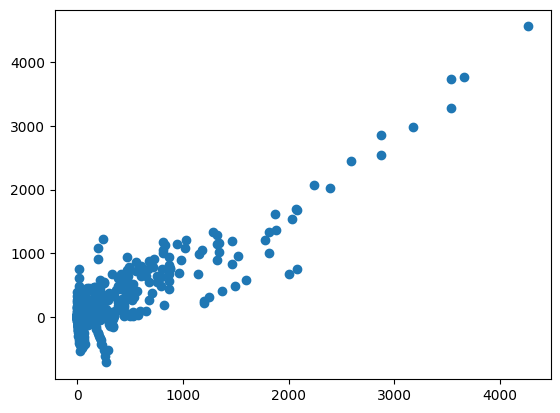

In [22]:
predictor.clear_reshaped_model_data()

with do(actions = {"limit": (factual_intervention)}):
    factual_intervention_samples =  predictor.predictive(predictor.nonified_data, 
                                        )

factual_intervention_samples['destandardized_housing_units_cumulative'] = (factual_samples['predicted_housing_units_cumulative'] *
                                                predictor.data['housing_units_cumulative_std'] +
                                                predictor.data['housing_units_cumulative_mean'])


summary_factual_intervention = summarize_time_series(
                                factual_intervention_samples,
                                y_true_original, y_site="destandardized_housing_units_cumulative",
                                clamp_at_zero=True)

plot_model_summary(summary_factual_intervention, y_true_original, 
                   title="Posterior predictive check (denstandardized)",
                   path = "ts_model_summary_cumulative.png")

print(summary_factual_intervention.keys())

plt.scatter(y_true_original,
            factual_intervention_samples['destandardized_housing_units_cumulative'].mean(dim = 0))
plt.plot()

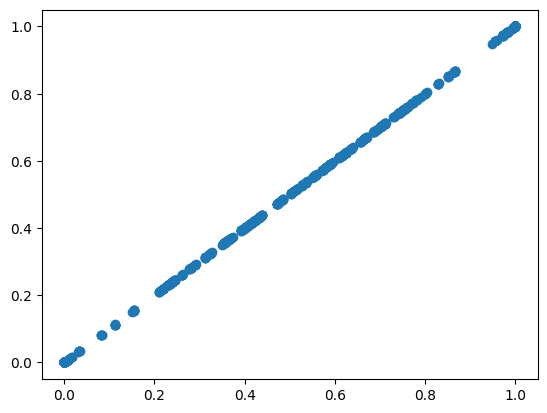

In [23]:
actual_limit = predictor.nonified_data['continuous']['mean_limit_original']


#plt.scatter(actual_limit, factual_intervention)

plt.scatter(actual_limit, factual_intervention_samples['limit'].mean(dim = 0))

In [32]:
predictor.clear_reshaped_model_data()

with do(actions = {"limit": (extreme_intervention)}):
    extreme_intervention_samples =  predictor.predictive(predictor.nonified_data, 
                                        )

extreme_intervention_samples['destandardized_housing_units_cumulative'] = (
                extreme_intervention_samples['predicted_housing_units_cumulative'] *
                predictor.data['housing_units_cumulative_std'] +
                predictor.data['housing_units_cumulative_mean'])


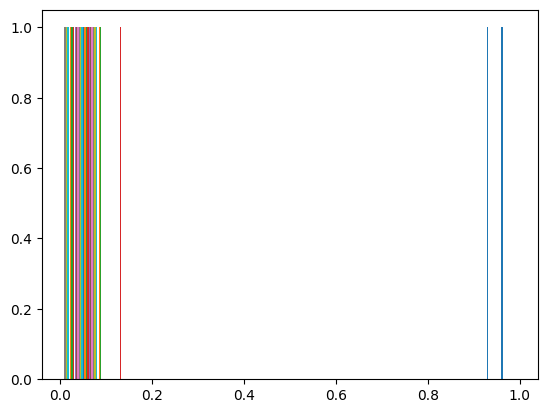

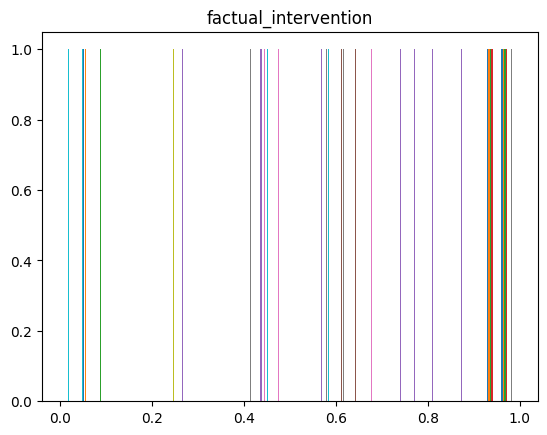

In [40]:
plt.hist(extreme_intervention_samples['limit'].mean(dim = 0))
plt.show()

plt.hist(factual_intervention_samples['limit'].mean(dim = 0))
plt.title("factual_intervention")
plt.show()

[]

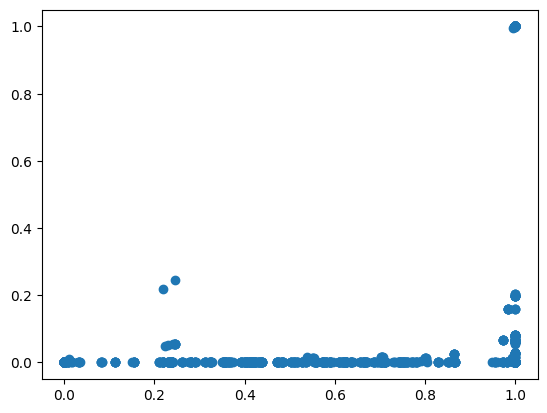

In [44]:
plt.scatter(factual_intervention_samples['limit'].mean(dim = 0),
            extreme_intervention_samples['limit'].mean(dim = 0))
plt.plot()

observed tensor([ 1314.,  5523.,  9583., 11894., 13943., 17888., 21612., 25977., 31165.,
        35157.])
intervened tensor([ 1314.0000,  6872.6040, 10937.5078, 13842.0342, 16316.4141, 19704.0859,
        23073.8828, 26957.7656, 31149.8398, 34708.0273])


[]

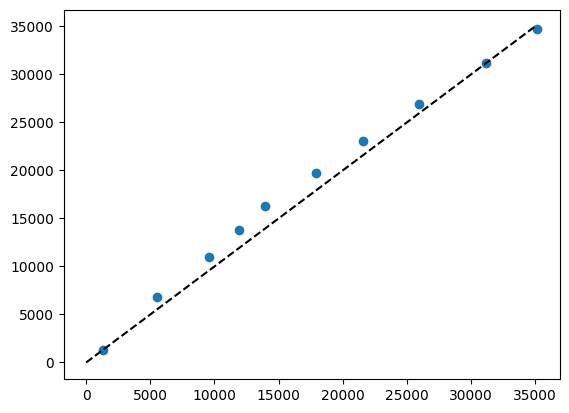

In [60]:
mean_intervened_pred = extreme_intervention_samples[
    'destandardized_housing_units_cumulative'].clamp(min = 0).mean(dim=0).squeeze()
mean__intervened_low = extreme_intervention_samples[
    'destandardized_housing_units_cumulative'].quantile(0.05, dim=0).squeeze()
mean__intervened_high = extreme_intervention_samples[
    'destandardized_housing_units_cumulative'].quantile(0.95, 
                                                        dim=0).squeeze()


#mean_intervened_pred = torch.clamp(mean_intervened_pred, min=0)
#mean_intervened_low = torch.clamp(mean__intervened_low, min=0)
#mean_intervened_high = torch.clamp(mean__intervened_high, min=0)


sum_observed = torch.sum(y_true_original, dim=0)
sum_intervened = torch.sum(mean_intervened_pred, dim=0)

print("observed", sum_observed)
print("intervened", sum_intervened)


plt.scatter(sum_observed, sum_intervened)
plt.plot([0, 35000], [0, 35000], color='black', linestyle='--')
plt.plot()



# plt.scatter(summary_factual_intervention['mean_pred'],
#             mean_intervened_pred)

# # add x=y line
# plt.plot([0, 1000], [0, 1000], color='black', linestyle='--')
# plt.plot()


In [20]:
from chirho.interventional.handlers import do
from chirho.counterfactual.handlers import MultiWorldCounterfactual


predictor.clear_reshaped_model_data()
with MultiWorldCounterfactual() as mwc:
    with do(actions = {"limit": (factual_intervention, extreme_intervention)}):
        samples =  predictor.predictive(predictor.nonified_data, 
                                        )

limit = samples['limit']
outcome = samples['predicted_housing_units_cumulative']

#.view(..., predictor.data['n_series'], predictor.data['T'])

print("limit", limit.shape)
print("raw outcome", outcome.shape)    


with mwc:
    factual_limit = gather(limit, IndexSet(**{"limit": {0}}), event_dims=0)
    low_limit = gather(limit, IndexSet(**{"limit": {1}}), event_dims=0)
    high_limit = gather(limit, IndexSet(**{"limit": {2}}), event_dims=0)

    # note this is needed o/w indices are wrong!
    outcome = outcome.squeeze(-1)
    print(limit.shape)
    print(outcome.shape)
    print(indices_of(outcome))
    factual_units = gather(outcome, IndexSet(**{"limit": {0}}), event_dims=0).squeeze().view(predictor.num_samples,predictor.data['n_series'],predictor.data['T'])
    low_units = gather(outcome, IndexSet(**{"limit": {1}}), event_dims=0).squeeze().view(predictor.num_samples,predictor.data['n_series'],predictor.data['T'])
    high_units = gather(outcome, IndexSet(**{"limit": {2}}), event_dims=0).squeeze().view(predictor.num_samples,predictor.data['n_series'],predictor.data['T'])


limit torch.Size([100, 1, 3, 1, 1, 1, 1130])
raw outcome torch.Size([100, 1, 1, 3, 10, 1, 1, 113, 1])
torch.Size([100, 1, 3, 1, 1, 1, 1130])
torch.Size([100, 1, 1, 3, 10, 1, 1, 113])
IndexSet({'limit': {0, 1, 2}})


tensor(404.6760) tensor(154.0319)
torch.Size([113, 10])
observed torch.Size([113, 10])
torch.Size([100, 113, 10])


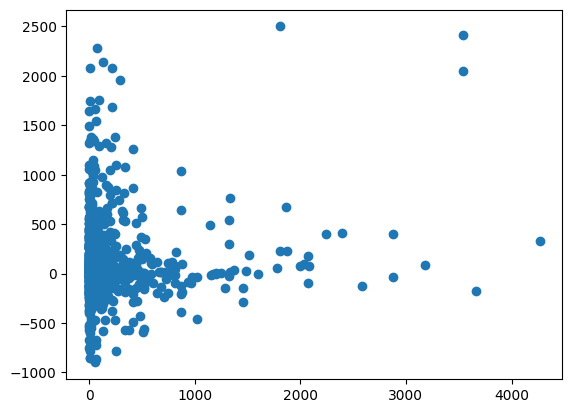

In [23]:
# print(predictor.data.keys())

print(predictor.data['housing_units_cumulative_std'],
       predictor.data['housing_units_cumulative_mean'])

print(predictor.data['reshaped']["continuous"]["housing_units_cumulative_original"].shape)

def destandardize_housing_units_cumulative(value):
    return value * predictor.data['housing_units_cumulative_std'] + predictor.data['housing_units_cumulative_mean']


observed_units = predictor.data['reshaped']["continuous"]["housing_units_cumulative_original"]
print("observed", observed_units.shape)

print(factual_units.shape)

factual_units_destandardized = destandardize_housing_units_cumulative(factual_units).squeeze()
low_units_destandardized = destandardize_housing_units_cumulative(low_units).squeeze()
high_units_destandardized = destandardize_housing_units_cumulative(high_units).squeeze()


plt.scatter(observed_units.flatten(), factual_units_destandardized.mean(dim = 0), label = "factual")
plt.show()



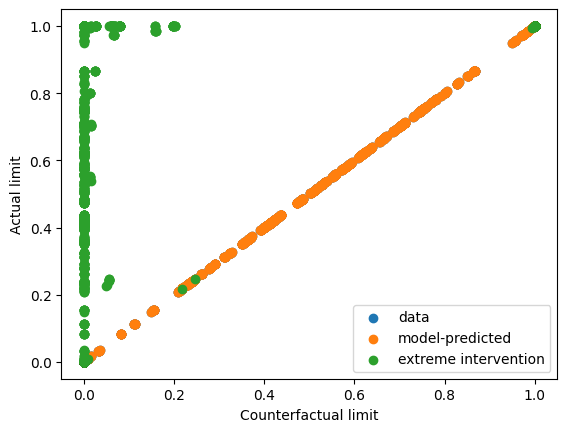

In [41]:
plt.scatter(observed_limit.mean(dim = 0).squeeze(), actual_limit, label = "data")
plt.scatter(low_limit.mean(dim = 0).squeeze(), actual_limit, label = "model-predicted")
plt.scatter(high_limit.mean(dim = 0).squeeze(), actual_limit, label = "extreme intervention")
plt.xlabel("Counterfactual limit")
plt.ylabel("Actual limit")
plt.legend()
plt.show()

# this is as expected

In [50]:
actual_cumulative = predictor.data['continuous']['housing_units_cumulative_original']


# plt.scatter(observed_limit.mean(dim = 0).squeeze(), actual_limit, label = "data")
# plt.scatter(low_limit.mean(dim = 0).squeeze(), actual_limit, label = "model-predicted")
# plt.scatter(high_limit.mean(dim = 0).squeeze(), actual_limit, label = "extreme intervention")
# plt.xlabel("Counterfactual limit")
# plt.ylabel("Actual limit")
# plt.legend()
# plt.show()


In [16]:

y_true = predictor.data['reshaped']['continuous']['housing_units_cumulative_original']


factual_samples['destandardized_housing_units_cumulative'] = (factual_samples['predicted_housing_units_cumulative'] *
                                                predictor.data['housing_units_cumulative_std'] +
                                                predictor.data['housing_units_cumulative_mean'])

factual_samples['bias_arima_housing_units_cumulative'].shape

# summary_destandardized = summarize_time_series(samples,
#                                 y_true, y_site="destandardized_housing_units_cumulative",
#                                 clamp_at_zero=True)

# plot_model_summary(summary_destandardized, y_true_original, 
#                    title="Posterior predictive check (denstandardized)",
#                    path = "ts_model_summary_cumulative.png")

# factual_samples['city_housing_units_observed'] = y_true.sum(dim=-2)
# factual_samples['city_housing_units_predicted'] = factual_samples['destandardized_housing_units_cumulative'].sum(dim=-2)


# samples.keys()

# samples['city_housing_units_observed'] = y_true_original.sum(dim=-2)
# samples['city_housing_units_predicted'] = samples['destandardized_housing_units_cumulative'].sum(dim=-2)

# summary_citywide = summarize_time_series(samples, samples['city_housing_units_observed'], y_site='city_housing_units_predicted')



# plot_model_summary(summary_citywide, samples['city_housing_units_observed'], title="Citywide cumulative housing units prediction", path = "citywide_housing_units_cumulative.png")

# factual_samples['limit'].shape
#summary = summarize_time_series(samples, y_true, y_site="predicted_housing_units_cumulative")
#plot_model_summary(summary, y_true, waic=waic, title="posterior predictive check", 
#                   path = "cumulative model evaluation.png")

torch.Size([100, 1, 1])